In [1]:
!pip install PySpice
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sps
import pandas as pd #Leer archivos de Excel
from PySpice.Spice.Netlist import *
from PySpice.Unit import *

# Diseño de filtro Butterworth Pasa Altas

## Paola Briseño, UAM - I, 2022.

Diseño y simulación (teórico/SPICE) de un filtro pasa-altas con la siguiente especificación:

máxima atenuación en la banda de paso: 0.1 dB
mínima atenuación en la banda de rechazo: 60 dB
fp=100m1 y fr=1000m2 Hz,con m1=5 y m2=6


In [2]:
def aproximacion_butterworth(Ap, Ar, fp, fr):
    N = int(np.ceil((np.log10((10**(Ap/10)-1)/(10**(Ar/10)-1)))/(2*np.log10(fp/fr))))
    fc = fp/(10**(Ap/10)-1)**(1/(2*N))
    return N, fc

In [3]:
def butterworth_pasaaltas(N, fc):
  # Calcula los polos
    p = np.array([np.exp(1j*(2*k-1)*np.pi/(2*N))*(np.exp(-1j*np.pi/2)) for k in range(1, 2*N+1)])
    p = np.array([2*np.pi*fc*pi for pi in p if pi.real <= 0])
  # Genera los coeficientes de H(s)
    a = np.poly(p).real 
    b = np.array([[1]+[0]*N])
  # Ordena los polos para hacer las secciones
    inx = np.argsort(p.real)
    p = p[inx]
  # Inicializa la lista de secciones
    s = []
  # Sección de orden uno, si la hay
    if N%2 != 0:
        bi = np.array([1,0])
        ai = np.array([1, -p[0].real])
        s.append([bi, ai])
      # Quita el polo real de la lista
        p = p[1:]
      # Secciones de orden dos
    for i in range(0, p.shape[0], 2):
        ai = np.poly(p[i:i+2]).real
        bi = np.array([1,0,0])
        s.append([bi, ai])
    return b, a, s

#  Comienza el diseño

In [4]:
# (Paso 1) Especificación relativa
Ap, fp, Ar, fr = 0.1, 500, 60, 6000
# (Paso 2) Parámetros del filtro
N, fc = aproximacion_butterworth(Ap, Ar, fp, fr)
# (Paso 3) Coeficientes de las secciones
b, a, s = butterworth_pasaaltas(N, fc)

In [5]:
print(b[0])
print(a)
print(N)
print(fc)

[1 0 0 0 0]
[1.00000000e+00 1.31343036e+04 8.62549659e+07 3.31818409e+11
 6.38244160e+14]
4
799.9573701523312


In [6]:
s[1]

[array([1, 0, 0]), array([1.00000000e+00, 3.84694847e+03, 2.52634946e+07])]

Text(0.5, 1.0, 'Pasa-altas, N=4')

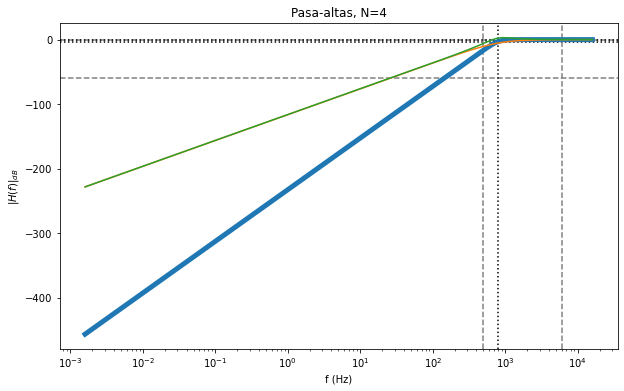

In [7]:
# Prepara gráfica con referencias relevantes (pasa altas)
plt.figure(figsize=(10, 6))
plt.axhline(-Ap, color='gray', linestyle='--')
plt.axhline(-Ar, color='gray', linestyle='--')
plt.axhline(-3, color='black', linestyle=':')
plt.axhline(0, color='black', linestyle=':')
plt.axvline(fp, color='gray', linestyle='--')
plt.axvline(fr, color='gray', linestyle='--')
plt.axvline(fc, color='black', linestyle=':')
# Respuesta en frecuencia total
W, H = sps.freqs(b[0],a)
f = W/(2*np.pi)
plt.semilogx(f, 20*np.log10(np.abs(H)), linewidth=5, label='total')
# Respuesta en frecuencia de cada sección
for i, [bi, ai] in enumerate(s):
    _, Hi = sps.freqs(bi, ai, W)
    plt.semilogx(f, 20*np.log10(np.abs(Hi)), label='sección {}'.format(i))
# Documenta la gráfica
plt.xlabel('f (Hz)')
plt.ylabel('$|H(f)|_{dB}$')
plt.title(f'Pasa-altas, N={N}')



In [8]:
def secciones_sallen_key(s, C=1e-6):
# Calcula los componentes de cada sección, usando como base C1=1uF.Regresa la lista sk = [[R1, R2, C2], [R1i, R2i, C1i, C2i], ....]
# con los␣ componentes de la sección de primer orden (si la hay) y los de las secciones de segundo␣orden

# Inicializa lista de componentes de sección
  sk = []
# Para cada sección
  for i, [bi, ai] in enumerate(s):
# Sección de primer orden
    if ai.shape[0] == 2:
      R = 1/(ai[1]*C)
      print('sección {}: R3={:6.3f}k, R4={:6.3f}k, C2={:6.3f}u'.format(i, R/1e3, R/1e3, C/1e-6))
      sk.append([R/1e3, R/1e3, C/1e-6])
      # Sección de segundo orden
    else:
      m = (ai[1]**2)/(4*ai[2])
      R3 = ai[1]/(2*m*ai[2]*C)
      R4 = ai[1]/(m*ai[2]*C)-R3
      print('sección {}: R3={:6.3f}k, R4={:6.3f}k, C1={:6.3f}u, C2={:6.3f}u'.format(i, R3/1e3, R4/1e3, C/1e-6, m*C/1e-6))
      sk.append([R3/1e3, R4/1e3, C/1e-6, m*C/1e-6])
  return sk

In [9]:
def sallen_key_pasaaltas_spice(sk, spiceopus=False):
    """Genera una lista de red (netlist) para SPICE a partir de los componentes␣exactos"""
    # Cadenas paramétricas de elementos del netlist
    MODELOS = '* Modelos\n.include tl081.mod\n'
    SENAL = '* Fuente de señal\nVin (vin 0) dc 0 ac 1.0v\n'
    ALIMENTACION = '* Fuentes de alimentación\nVpp (vp 0) dc 15\nVnn (0 vn) dc 15\n'
    #POrc = '*Seccion {0}\nR3{0} ({4} vi{0}) {1}k\nR4{0} (vi{0} {5}) {2}k\nC2{0}␣(vi{0} {5}) {3}u\n'
    POrc = '*Seccion {0}\nC1{0} ({4} vi{0}) {1}u\nC2{0} (vi{0} {5}) {2}u\nR2{0} (vi{0} {5}) {3}u\n'
    POopamp = 'X{0} (0 vi{0} vp vn {2}) TL081\n'
    #SKrc = '*Seccion {0}\nR3{0} ({5} n0{0}) {1}k\nR4{0} (n0{0} vni{0}) {2}k\nC1{0} (n0{0} {6}) {3}u\nC2{0} (vni{0} 0) {4}u\n'
    SKrc = '*Seccion {0}\nC1{0} ({5} n0{0}) {1}u\nC2{0} (n0{0} vni{0}) {2}u\nR3{0} (n0{0} {6}) {3}k\nR4{0} (vni{0} 0) {4}k\n'
    SKopamp = 'X{0} (vni{0} {1} vp vn {1}) TL081\n'
    CTRL = '* Simulacion\n.control\ndestroy all\nac dec 10 0.1Hz 10MegHz\nplot db(mag(v(vout)/v(vin))) vs frequency\n+ xlabel "f (Hz)"\n+ ylabel "|H(f)|dB"\n.endc\n.end'
    # Inicializa el netlist con el encabezado básico
    netlist = MODELOS + SENAL + ALIMENTACION
    # Agrega cada sección
    for i, ski in enumerate(sk):
        # Secciones de segundo orden Sallen-Key
        if len(ski) == 4:
            if i == 0:
            #   netlist = netlist + SKrc.format(i, ski[0], ski[1], ski[2], ski[3], 'vin', 'vout0')
                netlist = netlist + SKrc.format(i, ski[2], ski[3], ski[1], ski[0], 'vin', 'vout0')
                netlist = netlist + SKopamp.format(i, 'vout0')
            elif i == len(sk)-1:
                netlist = netlist + SKrc.format(i, ski[2], ski[3], ski[1], ski[0], 'vout{}'.format(i-1), 'vout')
                netlist = netlist + SKopamp.format(i, 'vout')
            else:
                netlist = netlist + SKrc.format(i, ski[2], ski[3], ski[2], ski[3], 'vout{}'.format(i-1), 'vout{}'.format(i))
                netlist = netlist + SKopamp.format(i, 'vout{}'.format(i))
        # Sección inversora de primer orden
        else:
            if i == 0:
                netlist = netlist + POrc.format(i, ski[2], ski[1], ski[0],'vin', 'vout0')
                netlist = netlist + POopamp.format(i, 'vin', 'vout0')
            elif i == len(sk)-1:
                netlist = netlist + POrc.format(i, ski[2], ski[1], ski[0],'vout{}'.format(i-1),'vout')
                netlist = netlist + POopamp.format(i, 'vout{}'.format(i-1),'vout')
            else:
                netlist = netlist + POrc.format(i, ski[2], ski[1], ski[0],'vout{}'.format(i-1), 'vout{}'.format(i))
                netlist = netlist + POopamp.format(i, 'vout{}'.format(i-1),'vout{}'.format(i))
       # Si se prefiere el netlist para SPICEopus
    if spiceopus:
        netlist = netlist + CTRL

    return netlist

# Continuación del diseño

In [10]:
#(Paso 4) Calcula componentes de las secciones
sk = secciones_sallen_key(s)
#(Paso 5) Simulación realista (SPICE) vs modelo (Python/Octave)
circuit = Circuit('PySPICE')
circuit.raw_spice = sallen_key_pasaaltas_spice(sk, spiceopus=True)
sim = circuit.simulator().ac(start_frequency=10@u_Hz, stop_frequency=0.1@u_MHz, number_of_points=10, variation='dec')

sección 0: R3= 0.215k, R4= 0.215k, C1= 1.000u, C2= 0.854u
sección 1: R3= 0.520k, R4= 0.520k, C1= 1.000u, C2= 0.146u


OSError: cannot load library 'C:\Users\ichbi\anaconda3\lib\site-packages\PySpice\Spice\NgSpice\Spice64_dll\dll-vs\ngspice.dll': error 0x7e.  Additionally, ctypes.util.find_library() did not manage to locate a library called 'C:\\Users\\ichbi\\anaconda3\\lib\\site-packages\\PySpice\\Spice\\NgSpice\\Spice64_dll\\dll-vs\\ngspice.dll'

In [11]:
sk

[[0.21534656153970227, 0.21534656153970227, 1.0, 0.8535533905932734],
 [0.5198925894795611, 0.5198925894795611, 1.0, 0.14644660940672644]]

In [12]:
import PySpice
PySpice.__version__

'1.5'

In [13]:
# Despliega el netlist SPICE
print(circuit)

.title PySPICE
* Modelos
.include tl081.mod
* Fuente de señal
Vin (vin 0) dc 0 ac 1.0v
* Fuentes de alimentación
Vpp (vp 0) dc 15
Vnn (0 vn) dc 15
*Seccion 0
C10 (vin n00) 1.0u
C20 (n00 vni0) 0.8535533905932734u
R30 (n00 vout0) 0.21534656153970227k
R40 (vni0 0) 0.21534656153970227k
X0 (vni0 vout0 vp vn vout0) TL081
*Seccion 1
C11 (vout0 n01) 1.0u
C21 (n01 vni1) 0.14644660940672644u
R31 (n01 vout) 0.5198925894795611k
R41 (vni1 0) 0.5198925894795611k
X1 (vni1 vout vp vn vout) TL081
* Simulacion
.control
destroy all
ac dec 10 0.1Hz 10MegHz
plot db(mag(v(vout)/v(vin))) vs frequency
+ xlabel "f (Hz)"
+ ylabel "|H(f)|dB"
.endc
.end




# Mediciones d ela implementación

In [22]:
# Extraer ruta del archivo de mediciones
path = 'med_PA.xlsx'
#Datos completos de la tabla:
datos = pd.read_excel(path)
datos

,Frec (Hz),Vin (V),Vout(V),Vout (V)dB
0,51.54,1.16,0.38,-8.404328
1,101.60,1.16,0.34,-9.370422
2,149.00,1.08,0.40,-7.958800
3,201.60,1.16,0.40,-7.958800
4,248.70,1.12,0.40,-7.958800
5,309.80,0.96,0.27,-11.372725
6,409.80,1.04,0.29,-10.752040
7,508.10,1.02,0.33,-9.629721
8,607.60,1.02,0.37,-8.635966
9,798.70,1.00,0.40,-7.958800


In [23]:
# Extraer ruta del archivo de mediciones Spice
path = 'PA_spice.xlsx'
#Datos completos de la tabla:
spice = pd.read_excel(path)
#spice
spice

,Frec (Hz),Vin (V),Vout(V),Vout (V)dB
0,50.100,1,NaN,-96.550000
1,99.960,1,NaN,-71.560000
2,155.340,1,NaN,-57.036000
3,204.230,1,NaN,-48.320000
4,252.690,1,NaN,-42.509000
5,303.220,1,NaN,-37.270000
6,404.760,1,NaN,-29.720000
7,508.420,1,NaN,-23.910000
8,600.900,1,NaN,-19.840000
9,802.180,1,NaN,-14.610000


Text(0.5, 1.0, 'Pasa-altas, N=4')

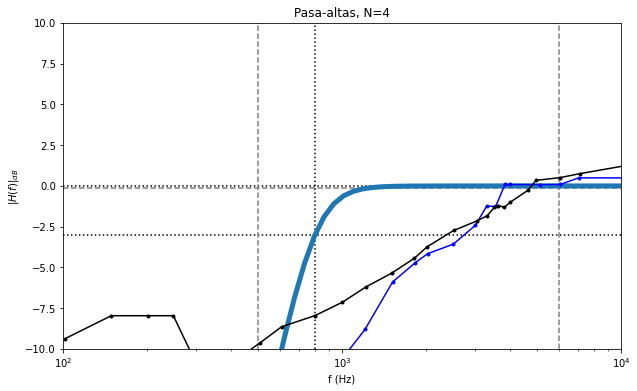

In [32]:
# Prepara gráfica con referencias relevantes (pasa altas)
plt.figure(figsize=(10, 6))
plt.axhline(-Ap, color='gray', linestyle='--')
plt.axhline(-Ar, color='gray', linestyle='--')
plt.axhline(-3, color='black', linestyle=':')
plt.axhline(0, color='black', linestyle=':')
plt.axvline(fp, color='gray', linestyle='--')
plt.axvline(fr, color='gray', linestyle='--')
plt.axvline(fc, color='black', linestyle=':')

# Respuesta en frecuencia total
W, H = sps.freqs(b[0],a)
f = W/(2*np.pi)
plt.semilogx(f, 20*np.log10(np.abs(H)), linewidth=5, label='total')

#Gráfica de las mediciones en la simulación spice
f_spice = spice.iloc[1:, 0]
H_spice = spice.iloc[1:, 3]
plt.semilogx(f_spice, H_spice, color='blue', linestyle='-', marker='.', label='SPICE')
plt.axis([100, 10000, -10, 10])

#Gráfica de las mediciones en la implementación
f_med = datos.iloc[1:, 0]
H_med = datos.iloc[1:, 3]
plt.semilogx(f_med, H_med, color='black', linestyle='-', marker='.', label='MEDICIONES')
plt.axis([100, 10000, -10, 10])

# Documenta la gráfica
plt.xlabel('f (Hz)')
plt.ylabel('$|H(f)|_{dB}$')
plt.title(f'Pasa-altas, N={N}')
